In [1]:
import numpy as np
from last_week import same
from numpy import ndarray
from numpy.typing import ArrayLike

In [2]:
Kmat = np.load("Chladni-Kmat.npy")

Implement centers,radii = gershgorin(A)

In [191]:
def gershgorin(A : ArrayLike) -> (ndarray, ndarray):
    radii = np.empty(A.shape[0])
    for i in range(A.shape[0]):
        # Sum of absolute values of all elements in row i, minus the absolute value of the diagonal element
        # this will most likely give a dumb floating point error, but I choose to think I will be fine
        radii[i] = np.sum(np.abs(A[i,:])) - np.abs(A[i,i])
        
    centers = np.diag(A)
    
    return centers, radii

Localize the eigenvalues of K, and report the disk centers and radii

In [225]:
centers, radii = gershgorin(Kmat)

print("The centers are: ", centers)
print("The radii are: ", radii)

The centers are:  [1.29292219e+05 1.03041439e+05 6.49675787e+04 4.36124119e+04
 3.62737515e+04 3.79900994e+04 2.41669711e+04 1.16511587e+04
 1.38650805e+04 5.60054767e+03 1.17303879e+03 1.76077135e+03
 2.88423061e+02 8.68968906e+01 1.38933458e+01]
The radii are:  [4.22316467e+04 5.69275189e+04 3.11606709e+04 1.85323487e+04
 7.87051614e+03 1.78547026e+04 1.54147167e+04 2.51204139e+03
 5.50296953e+03 1.19528329e+03 3.41990248e+02 4.01214726e+02
 7.14173194e+01 2.54029437e+00 2.59094641e-01]


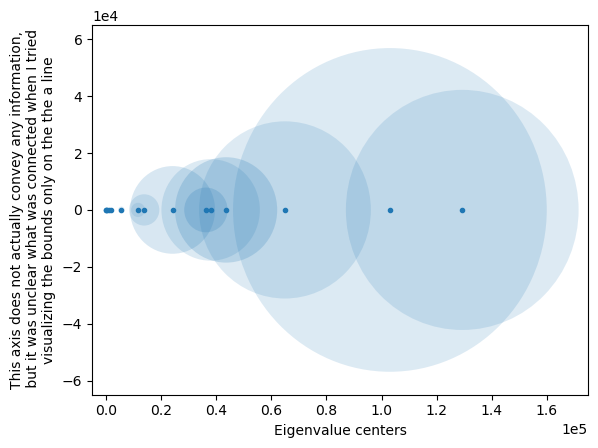

In [224]:
import matplotlib.pyplot as plt

circles = [plt.Circle((centers[i], 0), radii[i], alpha =  (np.random.random()+1)/10) for i in range(len(centers))]

fig, ax = plt.subplots()

for circle in circles:
    ax.add_patch(circle)

plt.plot(centers, np.zeros(len(centers)), '.')
plt.xlim(-5000 , 175000)
plt.ylim(-65000, 65000)

# make scientific notation
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel("Eigenvalue centers")
plt.ylabel("This axis does not actually convey any information,\n but it was unclear what was connected when I tried\nvisualizing the bounds only on the the a line")
plt.show()

Implement a function lambda = rayleigh_qt(A,x),

In [5]:
def rayleigh_qt(A : ArrayLike,x : ArrayLike) -> float:
    _lambda = x.T @ A @ x/(x.T @ x)
    return _lambda

Implement a function x, k = power iterate(A,x0) for power iteration. Don’t forget to choose and implement a suitable convergence criterion

In [226]:
def power_iterate(A : ArrayLike, x0 : ArrayLike) -> (ndarray, int):
    x0 = x0.copy()
    for k in range(1000):
        # copy for comparison
        ls = x0.copy()
        x0 = A @ x0

        x0 = x0/np.linalg.norm(x0)

        if (np.linalg.norm(x0 - ls) < 1e-8):
            break

    return x0, k

Test it by finding the largest eigenvalue of the example matrices. Report the eigenvalue found, the Rayleigh residual (the residual of the Raleigh quotient as a least-squares system), and the number k of iterations used. 

In [265]:
from Project2_examplematrices import *

examples = [A1, A2, A3, A4, A5, A6]
example_answers = [eigvals1, eigvals2, eigvals3, eigvals4, eigvals5, eigvals6]



# Define function to get rayleigh residual
def rayleigh_residual(A, x, eigval): 
    return np.linalg.norm(A@x - eigval*x)


for A, ans in zip(examples, example_answers):
    centers, radii = gershgorin(A)

    x, k = power_iterate(A, centers)
    lambd = rayleigh_qt(A, x)

    print("The eigenvalue is: ", lambd)
    print("The number of iterations is: ", k)
    print("The residual is: ", rayleigh_residual(A, x, lambd))

    print(same(lambd, ans[0]))


The eigenvalue is:  4.0
The number of iterations is:  1
The residual is:  0.0
True
The eigenvalue is:  4.0
The number of iterations is:  1
The residual is:  0.0
True
The eigenvalue is:  12.298958396123956
The number of iterations is:  17
The residual is:  2.3980522683105858e-08
True
The eigenvalue is:  16.11684396939325
The number of iterations is:  7
The residual is:  1.4556419180260206e-09
True
The eigenvalue is:  68.64208074059677
The number of iterations is:  6
The residual is:  9.18586217968749e-09
True
The eigenvalue is:  2.0000000000000004
The number of iterations is:  23
The residual is:  5.754343080042756e-09
True


What is the largest eigenvalue of K? Visualize your eigenfunction using show waves(x,basis set) to see the wave, and show nodes(x,basis set) to see where the sand will gather. The eigenfunction for the largest eigenvalue should have nodes along an 8 x 8 grid. 

The eigenvalue is:  151362.66647790238
The number of iterations is:  39


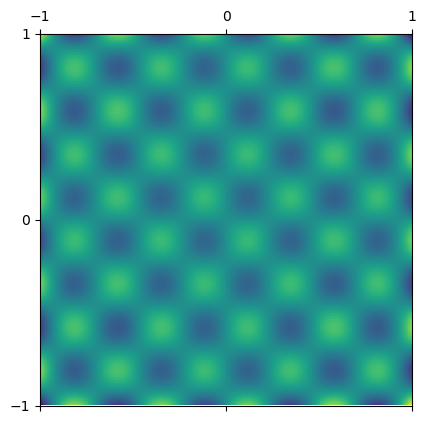

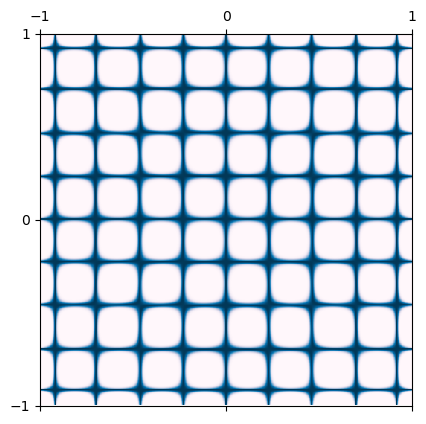

In [232]:
from chladni_show import show_waves, show_nodes
A = Kmat

centers, radii = gershgorin(A)

x, k = power_iterate(A, centers)

print("The eigenvalue is: ", lambd)
print("The number of iterations is: ", k)

lambd = rayleigh_qt(A, x)
show_waves(x)
show_nodes(x)


Write a Rayleigh quotient iteration function x, k = rayleigh iterate(A,x0, shift0), which takes a matrix A, an initial vector x0, and an approximate eigenvalue shift0 as arguments and returns an eigenvector x together with the number k of iterations used. The multiplication by the inverse matrix should be implemented using either your own LUfactorization from as x = lu solve(A,y) or QR-factorization from as x = qr solve(A,y). NB: If you did not get either to work in previous weeks, you can use an in-built linear solver and make a small note that you do this.

In [267]:
from last_week import solve_least_squares as lu_solve

def check_eigs(M, eigs):
    sames = []
    for a,b in zip(np.linalg.eig(M)[0], np.sort(eigs)[::-1]):
        # print(a,b)
        sames.append(same(a,b))
    
    return all(sames)


def rayleigh_iterate(A : ArrayLike, x0 : ArrayLike, shift0 : float) -> (ndarray, int, float):
    x = x0.copy()
    shift = shift0

    # checks for singular matrices
    matrix = A - shift0 * np.identity(A.shape[0])
    if np.linalg.det(matrix) == 0:
        shift = shift0 - 1e-11

    matrix = A - shift * np.identity(A.shape[0])
    if np.linalg.det(matrix) == 0:
        shift = shift0 + 1e-11


    # Do some shifted inverse iteration, so as to negate a bad choice of x0
    for i in range(5):
        y = lu_solve(A - shift * np.identity(A.shape[0]), x)
        if(np.isnan(x[0])):
            # Maybe do something here?
            continue

        x = y / np.linalg.norm(y)

    # starting the actual iterations
    for k in range(1,100):
        x = lu_solve(A - shift * np.eye(A.shape[0]), x)

        x = x/np.linalg.norm(x)

        shift = rayleigh_qt(A, x)

        # choosing to use the rayleigh residual as a stopping criterion
        residual = rayleigh_residual(A,x,shift)
        if (residual < 1e-8):
            break

    return x, k, shift

# A big helper function to get all eigenvalues without duplicates and the likes
def get_eigs(M, check = False, residuals = False):
    centers, radii = gershgorin(M)
    found_vecs = []
    found_vals = []
    found_iterations = []

    if residuals:
        found_residuals = []

    # for each circle
    for c, r in zip(centers, radii):
        # starting from the center, look at the right half of the circle, then the left half
        search_space = np.linspace(c - r, c + r, 101)
        search_space = np.append(search_space[50:], search_space[:50])
        good = False

        for initial in search_space:
            eigenvec, k, eigenval = rayleigh_iterate(M, -np.ones(M.shape[0]), initial)

            # if the matrix was singular, just continue and pretend nothing happened
            if eigenvec is None:
                print("None here")
                continue

            # check if we found a new eigenvalue
            if (np.abs(eigenval - c) <= r or np.isclose((np.abs(eigenval - c) - r), 0)) and not any([same(eigenval, v) for v in found_vals]):
                good = True
                break

        # throw errors if we didn't find anything that makes sense
        if check:
            assert good, "No eigenvalue found for "+ str(c)
            assert np.abs(eigenval - c) <= r or np.isclose((np.abs(eigenval - c) - r), 0), "Too far from center"

        found_vecs.append(eigenvec)
        found_vals.append(eigenval)
        found_iterations.append(k)

        if residuals:
            found_residuals.append(rayleigh_residual(M, eigenvec, eigenval))

    # check if we found all eigenvalues
    if check:
        assert check_eigs(M, found_vals), "Not all eigenvalues found" + str(found_vals) + str(np.linalg.eig(M)[0])

    # sort the eigenvalues and eigenvectors
    srt = np.argsort(found_vals)
    
    if residuals:
        return np.array(found_vecs)[srt], np.array(found_vals)[srt], np.array(found_residuals)[srt], np.array(found_iterations)[srt]
        
    return np.array(found_vecs)[srt], np.array(found_vals)[srt], np.array(found_iterations)[srt]



Test it with the example matrices, and report the eigenvalues found, Rayleigh residual, and the number k of iterations used. 

In [268]:
for example, answer in zip(examples, example_answers):
    eigs = get_eigs(example, residuals = True)
    print("values")
    print(eigs[1][::-1])
    print("answer")
    print(np.sort(answer)[::-1])
    print("residuals")
    print(eigs[2][::-1])
    print("iterations")
    print(eigs[3][::-1])

c:\Users\jakob\Documents\MscPhysics\Scientific Computing\Project2\last_week.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  x[k] = (y[k] - np.dot(U[k, (k+1):N], x[(k+1):N])) / U[k,k]
C:\Users\jakob\AppData\Local\Temp\ipykernel_11068\1008182145.py:33: RuntimeWarning: invalid value encountered in divide
  x = y / np.linalg.norm(y)


values
[ 4. -2.]
answer
[ 4 -2]
residuals
[6.28036983e-16 2.22044605e-16]
iterations
[1 1]
values
[4. 2.]
answer
[4 2]
residuals
[0.00000000e+00 2.22044605e-16]
iterations
[1 1]
values
[12.29895839 -0.95851014 -4.48057377]
answer
[12.29895839 -0.95851014 -4.48057377]
residuals
[5.71866674e-09 8.49610819e-16 6.66133815e-16]
iterations
[7 3 4]
values
[ 1.61168440e+01  1.81298661e-16 -1.11684397e+00]
answer
[16.11684397  0.         -1.11684397]
residuals
[3.95239397e-14 8.06982721e-16 2.75723901e-09]
iterations
[4 1 2]
values
[68.64208074 -3.64208074 -3.64208074 -3.64208074 -3.64208074]
answer
[68.64208074  0.          0.          0.         -3.64208074]
residuals
[3.74047270e-12 4.14228138e-15 1.26326153e-12 2.58763075e-12
 1.06404212e-10]
iterations
[7 3 2 3 4]
values
[2. 2. 1. 1. 1.]
answer
[2 2 2 1 0]
residuals
[8.02106995e-11 1.57634034e-12 3.96850276e-13 3.56395922e-12
 3.55992100e-16]
iterations
[1 3 3 2 4]


An important feature of inverse iteration and Rayleigh-iteration is the ability to calculate any eigenvalue and its eigenvectors: given an approximate starting point, we obtain an eigenvector to the nearest eigenvalue. Why can you not get all the eigenvalues and -vectors with pure poweriteration?

S

(2) Use your Rayleigh quotient iteration function together with the Gershgorin centers to calculate as many eigenvectors and eigenvalues of K as you can. Are you able to get all of them? Why? If not, find the remaining one(s) by any means necessary. Check using show nodes(x,basis set) that the eigenfunction with lowest eigenvalue looks like a cross: 

c:\Users\jakob\Documents\MscPhysics\Scientific Computing\Project2\last_week.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  x[k] = (y[k] - np.dot(U[k, (k+1):N], x[(k+1):N])) / U[k,k]
C:\Users\jakob\AppData\Local\Temp\ipykernel_11068\1008182145.py:33: RuntimeWarning: invalid value encountered in divide
  x = y / np.linalg.norm(y)


[1.38926073e+01 8.68802164e+01 2.86533307e+02 1.13221657e+03
 1.79980589e+03 5.56088120e+03 1.14852128e+04 1.33386223e+04
 2.25901985e+04 3.27790711e+04 3.61523700e+04 5.04300277e+04
 5.27662888e+04 9.39996141e+04 1.51362666e+05]


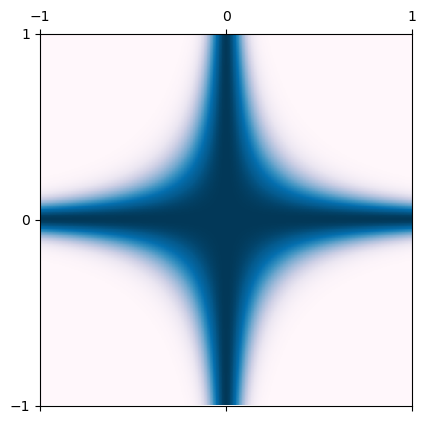

In [269]:
k_eigs = get_eigs(Kmat, check = True)

print(k_eigs[1])

show_nodes(k_eigs[0][0])

(3) Construct the transformation matrix T whose columns are the eigenvectors in order of ascending eigenvalues, and check that $K = T\Lambda T^{-1}$ with diagonal $\Lambda$ (4) Visualize your solution using the provided function show all wavefunction nodes(T,lambdas,basis set).

In [270]:
T = np.zeros_like(Kmat)

for i, ei in enumerate(k_eigs[0]):
    T[i] = ei

T = T.T

same(Kmat - T @ np.diag(k_eigs[1]) @ np.linalg.inv(T), np.zeros_like(Kmat))


True

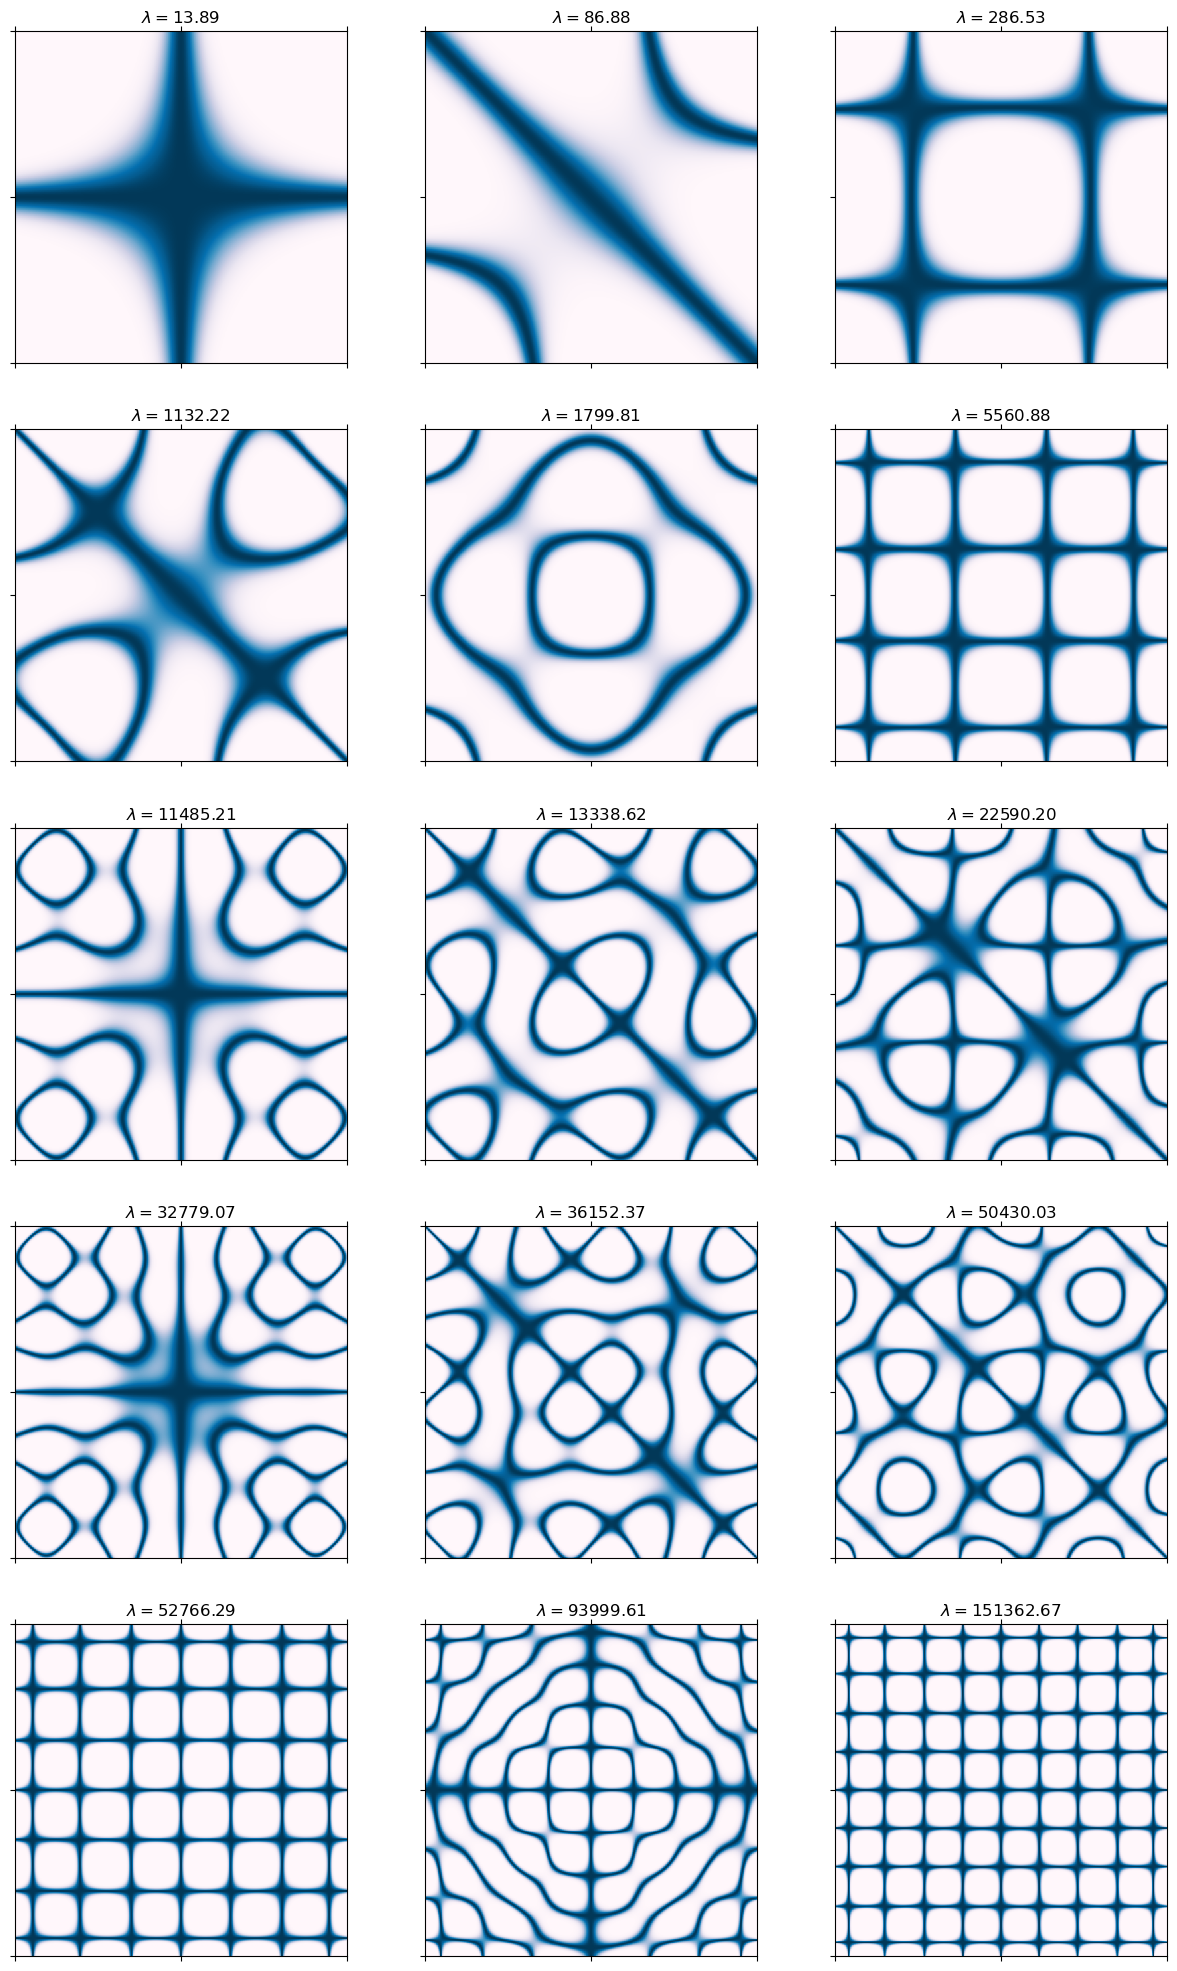

In [180]:
from chladni_show import show_all_wavefunction_nodes

show_all_wavefunction_nodes(T, k_eigs[1])